#AmeniDC
## See the cost of amenities in the District of Columbia

In [28]:
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 4 * matplotlib.rcParams['savefig.dpi']
import matplotlib.pylab as plt

# Define amenity types of interest
AMENITY_TYPES = ['bakery','bar','cafe','grocery_or_supermarket',
  'movie_theater','park','pharmacy','restaurant','school','spa','subway_station']

In [2]:
import simplejson as json
import requests
from requests import Request, Session
from bs4 import BeautifulSoup
import re

from urlparse import urljoin
from collections import namedtuple
import sqlite3
from pyspark.sql import SQLContext

import numpy as np
import pandas as pd

#import geojson
#from geojson import Feature, Point, FeatureCollection
import pprint
pp = pprint.PrettyPrinter(indent=0)

#OpenData.DC API

Get the property sale points from http://opendata.dc.gov/datasets/2acc75ccdd954267acecb8713b2b800a_28
and store as a SQL database pandas DataFrame

In [ ]:
from ediblepickle import checkpoint


@checkpoint(key='prop_sales_json.csv', work_dir='data', refresh=False)
def request_records():
  url = 'http://opendata.dc.gov/datasets/2acc75ccdd954267acecb8713b2b800a_28.geojson'
  with requests.Session() as s:
    resp = s.get(url)
    try:
        resp.raise_for_status()
    except requests.exceptions.HTTPError as e:
        print "And you get an HTTPError:", e.message
  return resp.json()
  
  
def build_df(resp_json):
  keep_cols = [u'ADDRESS1',u'ADDRESS2',u'ANNUALTAX',u'ASSESSMENT',
               u'BASEBUILD',u'BASELAND',u'CITYSTZIP',
               u'HIGHNUMBER',u'HSTDCODE',u'LANDAREA',u'LOT',
               u'LOWNUMBER',u'NBHD',
               u'NEWIMPR',u'NEWLAND',u'NEWTOTAL',
               u'OLDIMPR',u'OLDLAND',u'OLDTOTAL',u'OWNOCCT',
               u'PREMISEADD',u'PROPTYPE',u'QDRNTNAME',u'SALEDATE',
               u'SALEPRICE',u'SALETYPE',u'SQUARE',u'SSL',u'STREETCODE',u'STREETNAME',
               u'SUBNBHD',u'coordinates']
    
  row_dicts = []
  for feats in resp_json['features']:
    try:
      # get coordinates
      row = dict(zip(['longitude','latitude'],feats['geometry']['coordinates']))
    except:
      continue
    attrs = feats['properties'] # get select property attributes
    row.update(dict(( (k,attrs.get(k,'')) for k in keep_cols )))
    row_dicts.append(row)
    
  df = pd.DataFrame(row_dicts)
  print df.columns

  df['lat_lng'] = df.loc[:,('latitude','longitude')].apply(
      lambda row: str(row[0])+','+str(row[1]),axis=1)

  df.to_hdf('./data/df_cleaned_wo_amen.hd5','df')
  

if False:
  resp_json = request_records()
  print resp_json['features'][0]
if False:
  build_df(resp_json)

Only keep residential single family residences

In [ ]:
if False:
  df = pd.read_hdf('./data/df_cleaned_wo_amen.hd5','df')
  print df['PROPTYPE'].unique()
  df = df.loc[df['PROPTYPE']==u'RESIDENTIAL-SINGLE FAMILY',:].copy()
  print df['PROPTYPE'].unique()
  df.to_hdf('./data/df_cleaned_res_only.hd5','df')


Parse the zipcodes and remove zipcodes that aren't in DC

In [ ]:
from sklearn import cross_validation, grid_search, neighbors

def zip_parser(x):
  z = x.split()[-1][:5]
  try:
    zint = int(z)
    if len(z) == 5:
      return z
    else:
      return u''
  except:
    return u''
  
if False:
  df = pd.read_hdf('./data/df_cleaned_res_only.hd5','df')
  df['zipcode'] = df.CITYSTZIP.map(lambda r: zip_parser(r))

  #print df.zipcode.unique()

  # extract zips from CITYSTZIP column
  df['zipcode'] = df.CITYSTZIP.map(lambda r: zip_parser(r))
  

  # Use nearest neighbors to fill in missing
  param_grid = {"n_neighbors": range(4,10)}
  zip_model = grid_search.GridSearchCV( neighbors.KNeighborsClassifier(),
                  param_grid=param_grid,
                  cv=cross_validation.ShuffleSplit(len(df.index), n_iter=20, 
                      test_size=0.2,random_state=42) )

  zip_model.fit(df[['latitude','longitude']],df['zipcode'])
  for key in param_grid.keys():
    grid_score_plotter(zip_model,key)

  badzip = df.zipcode==''
  df.loc[badzip,'zipcode'] = zip_model.predict(df.loc[badzip,('latitude','longitude')])
  
  df.to_hdf('./data/df_cleaned_zipcodes.hd5','df')


# Google Maps Places API

Here, property sale locations are queried for nearby amenities. API requests were made once offline and pickled. Data for each lat_lng pair were stored as dict. 

Create a df column showing amenity_price_rating numbers for the top 20 hits within 1000m of the property

In [ ]:
if True:
  #df = pd.read_hdf('./data/df_cleaned_zipcodes.hd5','df')
  df = pd.read_hdf('./data/df_w_amen.hd5','df')


In [ ]:
if True:
  df = df.iloc[:15,:].copy()
  df.reset_index(inplace=True)

In [ ]:
len(df.columns)

In [ ]:
df.park

In [ ]:
import simplejson as json
import pandas as pd
from requests import Request, Session
from requests_futures.sessions import FuturesSession
from collections import namedtuple
import operator
import time


# Read in all API keys
with open("../secrets/google_secrets.json.nogit") as fh: 
  secrets = json.loads(fh.read())
google_api_key = secrets['server_api_key']

Summary = namedtuple('Summary',['count','count_rating','sum_rating','sum_rating_sq',
                               'count_price_level','sum_price_level','sum_price_level_sq'])

def google_places_parser(sess,resp):
  
  if False:
    print resp.json()['results'][0]
  
  count = 0
  count_rating = 0
  sum_rating = 0
  sum_rating_sq = 0
  count_price_level = 0
  sum_price_level = 0
  sum_price_level_sq = 0

  for r in resp.json()['results']:
    rating = r.get('rating')
    if rating:
      count_rating += 1
      sum_rating += float(rating)
      sum_rating_sq += float(rating)**2

    price_level = r.get('price_level')
    if price_level:
      count_price_level += 1
      sum_price_level += float(price_level)    
      sum_price_level_sq += float(price_level)**2    
    
    count += 1

  summary = Summary(count,count_rating,sum_rating,sum_rating_sq,
                   count_price_level,sum_price_level,sum_price_level_sq)

  resp.data = {'next_page_token':resp.json().get('next_page_token',''),
               'summary':summary}


def make_urls(npt_ll_series,amen_query):
  base_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"
  s = Session()
  
  urls = []
  for row in npt_ll_series:
    npt, ll = row
    if npt == '':
      search_payload = {"key":google_api_key,
                        "radius":1000,
                        "types":amen_query,
                        "location":ll}
    else:
      '''Including a page token forces Google to ignore all other
      search parameters'''
      search_payload = {"key":google_api_key,
                        'pagetoken':npt}

    req = Request('GET', base_url, params=search_payload)

    urls.append(s.prepare_request(req).url)
  
  return urls

In [ ]:
# Build up the dataframe
from itertools import izip

session = FuturesSession(max_workers=7)

start_time = time.time()
for k in range(10,4,-1):
  amenity = AMENITY_TYPES[k]
  df['next_page_token'] = ''
  df[amenity] = df.apply(lambda _: Summary(0,0,0,0,0,0,0),axis=1)
  get_more = df.index
  
  for i in xrange(3):
    urls = make_urls(df.ix[get_more,('next_page_token','lat_lng')].as_matrix(),amenity)    
    results = (session.get(url,background_callback=google_places_parser) 
               for url in urls)
    outputs = ((x.result().data['next_page_token'],x.result().data['summary']) 
               for x in results)

    npts,summaries = izip(*outputs)
    df.ix[get_more,amenity] = pd.Series((Summary(*map(operator.add,x[0],x[1]))
                                for x in izip(df.ix[get_more,amenity],summaries)),index=get_more)
    df.ix[get_more,"next_page_token"] = npts

    get_more = df.index[df.next_page_token != '']
    
    print i,len(get_more)
    if len(get_more) == 0:
      break
    time.sleep(2) # delay because next page is not immediately available
  
  if True:
    df.to_hdf('./data/df_w_amen.hd5','df')
    
print("--- %s seconds ---" % (time.time() - start_time))



In [36]:
el = '1234k1;2j34;1j234;'
print el[-10:]

j34;1j234;


### Find count and mean of each amenity ###

In [7]:
AMENITY_TYPES[5:11]

['park', 'pharmacy', 'restaurant', 'school', 'spa', 'subway_station']

In [8]:
if True:
  df = pd.read_hdf('./data/df_w_amen.hd5','df')


In [ ]:
if True:
  df = df.sample(100).copy()


In [10]:
len(df.index)

14501

In [11]:
def summarizer(x):
  '''x is a Summary named tuple'''
  nr = np.float64(x.count_rating)
  mu_r = x.sum_rating/nr
  sd_r = np.sqrt(x.sum_rating_sq/nr - mu_r**2)
  npl = np.float64(x.count_price_level)
  mu_p = x.sum_price_level/npl
  sd_p = np.sqrt(x.sum_price_level_sq/npl - mu_p**2)
  
  return (x.count,x.count_rating,mu_r,sd_r,x.count_price_level,mu_p,sd_p) 

In [12]:
for amenity in AMENITY_TYPES:
  sum_cols = ['count','count_rating','mean_rating','std_rating',
              'count_price_level','mean_price_level','std_price_level']
  df = pd.concat( [df,pd.DataFrame.from_records(df[amenity].map(lambda x: summarizer(x)).tolist(),
                    columns=[amenity + '_' + s for s in sum_cols],
                    index=df.index)], axis = 1
            )

In [13]:
if True:
  df.to_hdf('./data/df_w_amen_flat.hd5','df')

/opt/conda/lib/python2.7/site-packages/pandas/io/pytables.py:2577: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->axis0] [items->None]

  warnings.warn(ws, PerformanceWarning)
/opt/conda/lib/python2.7/site-packages/pandas/io/pytables.py:2577: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_items] [items->None]

  warnings.warn(ws, PerformanceWarning)
/opt/conda/lib/python2.7/site-packages/pandas/io/pytables.py:2577: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_items] [items->None]

  warnings.warn(ws, PerformanceWarning)
/opt/conda/lib/python2.7/site-packages/pandas/io/pytables.py:2577: PerformanceWarning: 
your performance may suffer as PyTables will pickle obj

#Visualize the data

In [14]:
df = df.loc[df.zipcode != '',:]
df = df.loc[df.zipcode.map(lambda x: int(x) > 19999 and int(x)<20600),:]

In [15]:
[col for col in df.columns if 'mean_rating' in col and '_count' not in col]

['bakery_mean_rating',
 'bar_mean_rating',
 'cafe_mean_rating',
 'grocery_or_supermarket_mean_rating',
 'movie_theater_mean_rating',
 'park_mean_rating',
 'pharmacy_mean_rating',
 'restaurant_mean_rating',
 'school_mean_rating',
 'spa_mean_rating',
 'subway_station_mean_rating']

In [39]:
plt.tight_layout?

In [40]:
def hist_plotter(df,cols,prefix=None):
  for attr in cols:
    plt.figure(figsize=(4,3))
    
    try:
      df[attr].hist(bins=20)
    except:
      pass
    plt.xlabel(attr)
    plt.ylabel('Number of sale locations')
    plt.tight_layout()
    plt.savefig('./static/images/'+attr+'.png',frameon=False,dpi=600,pad_inches=0.2)

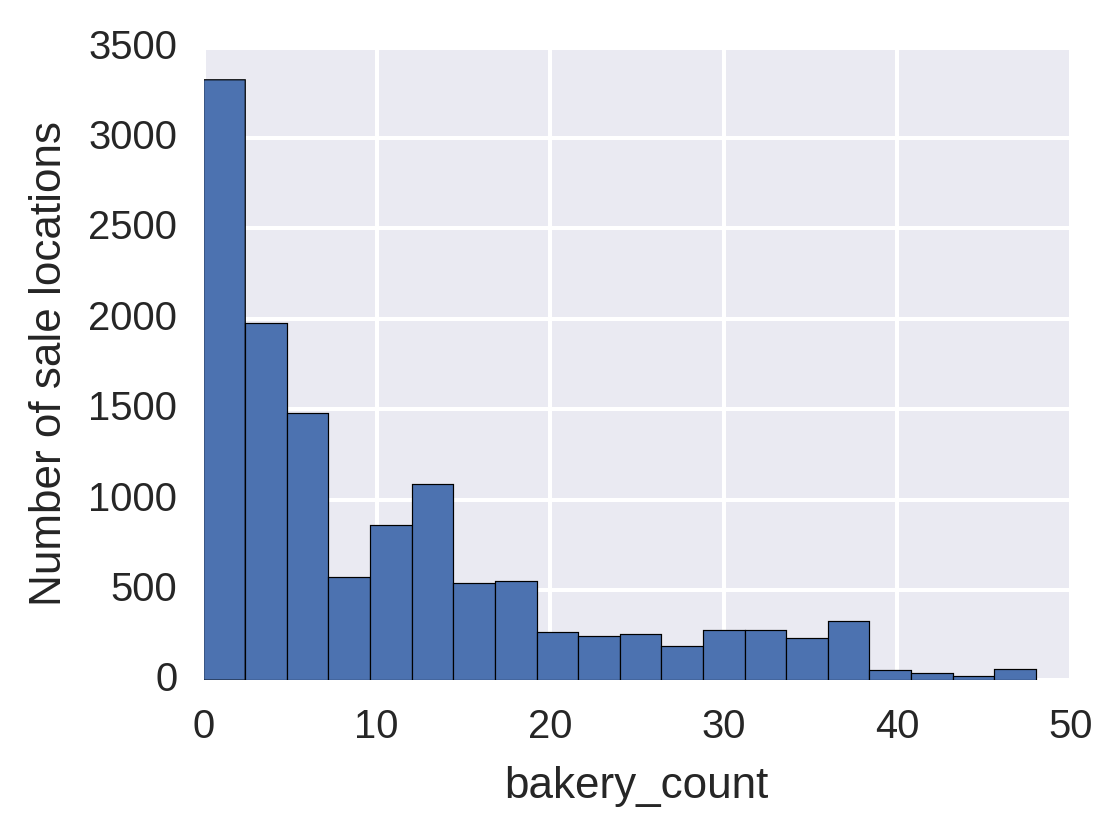

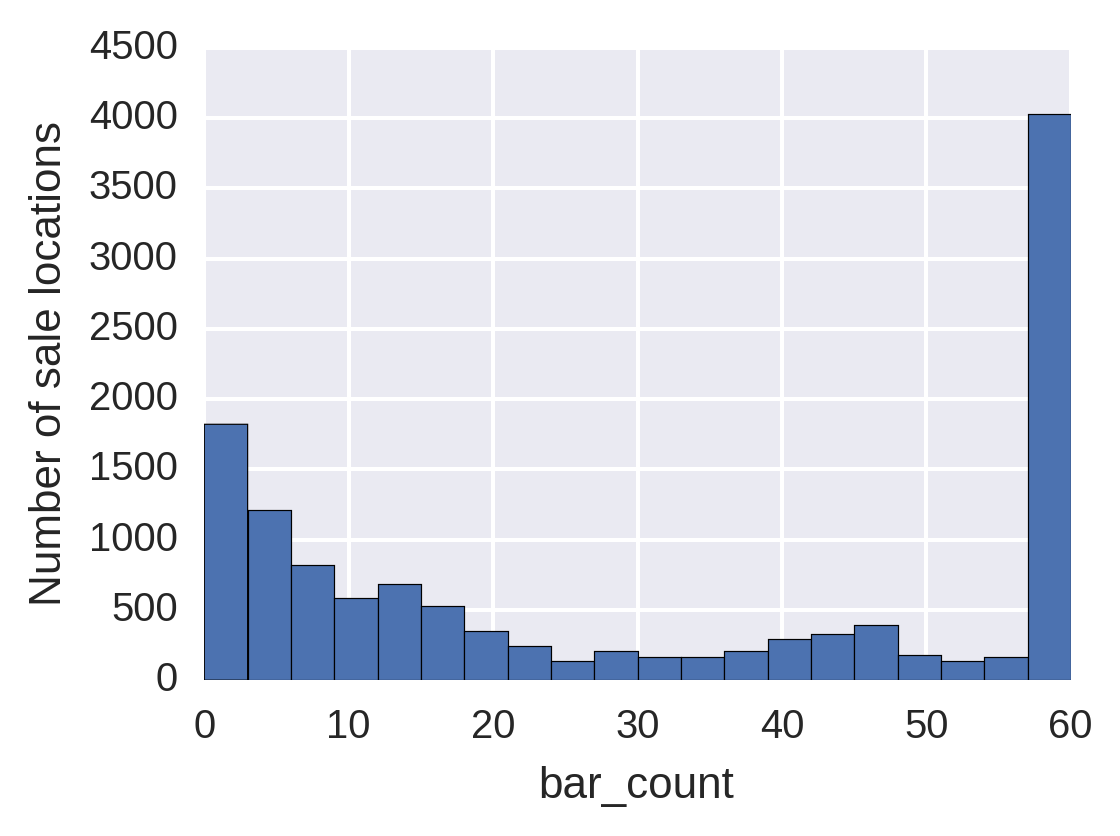

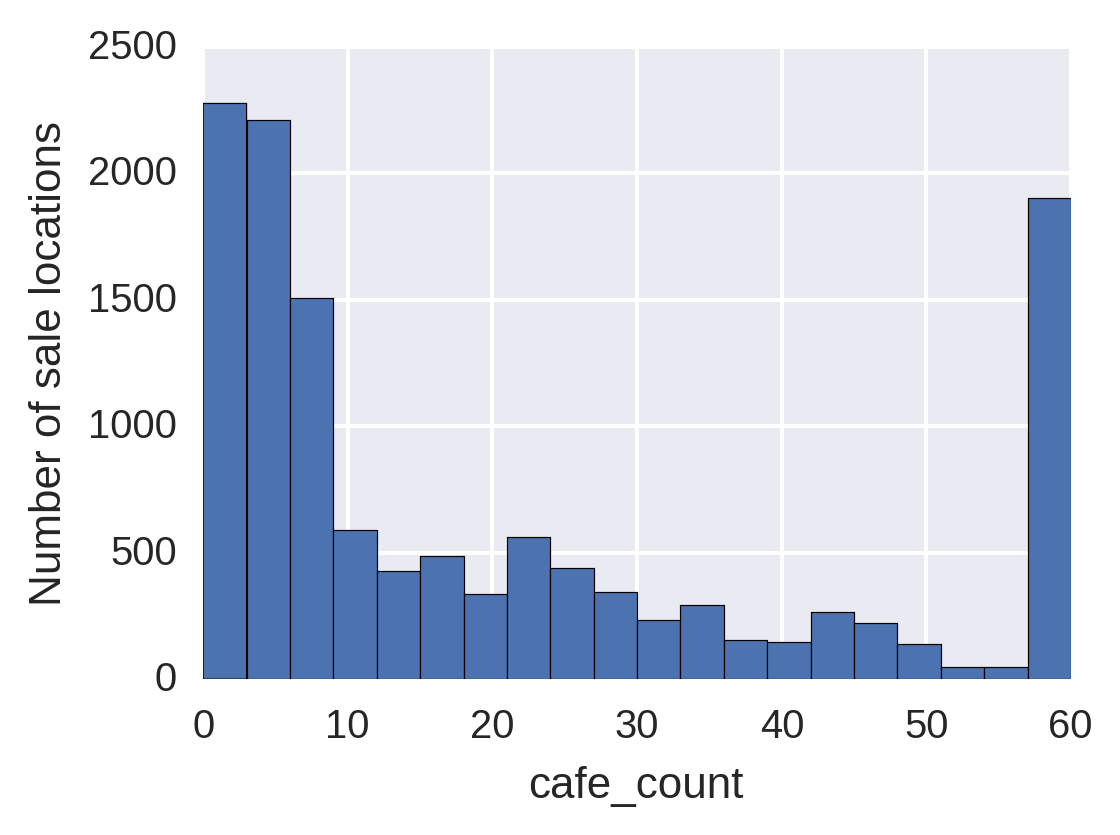

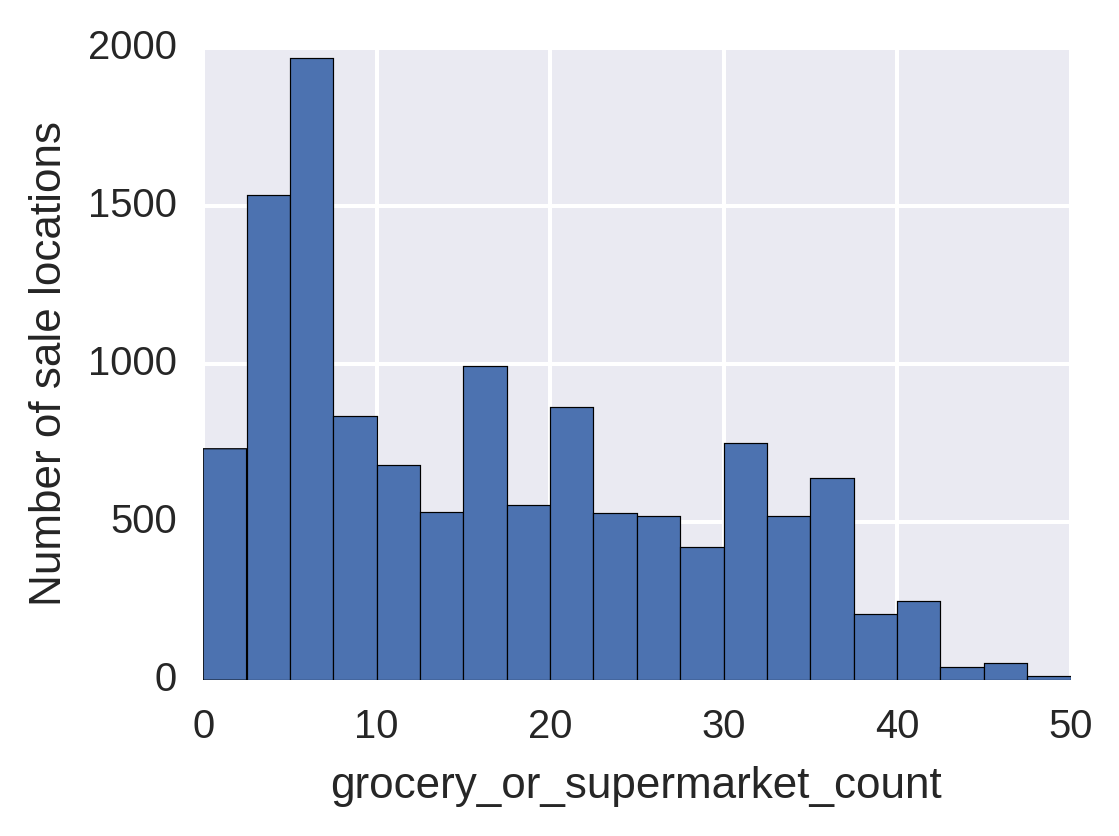

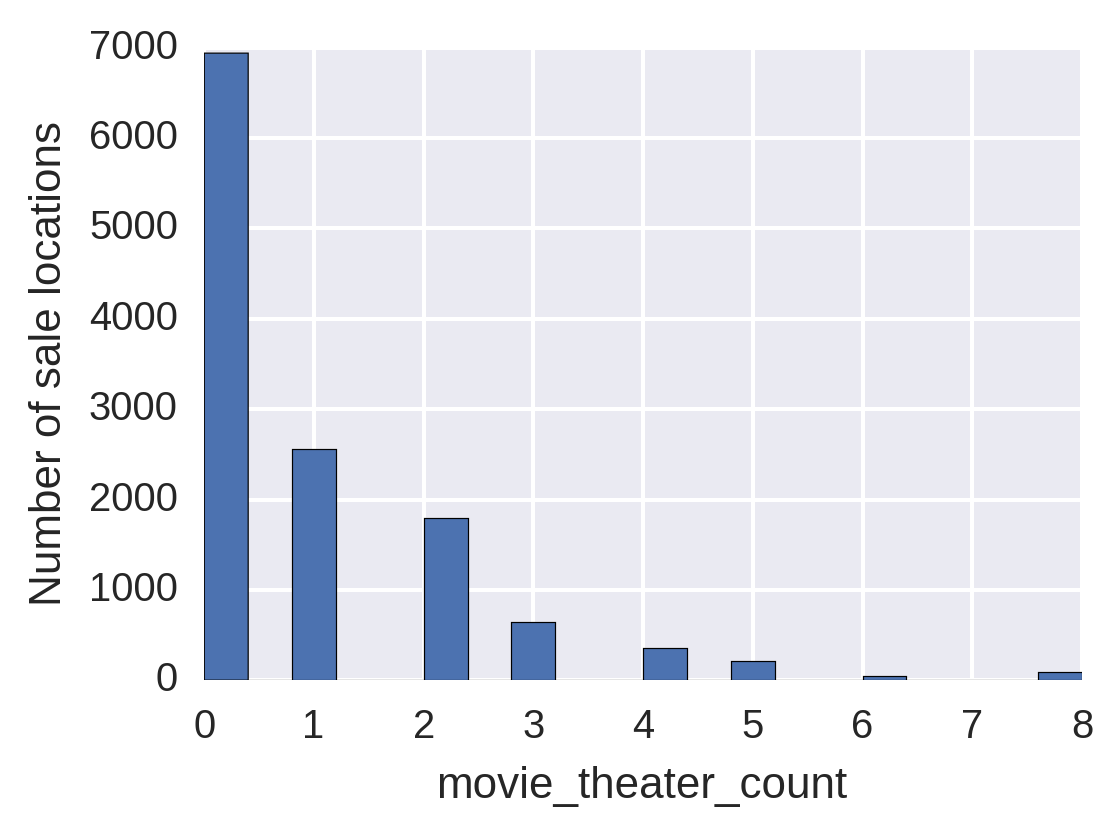

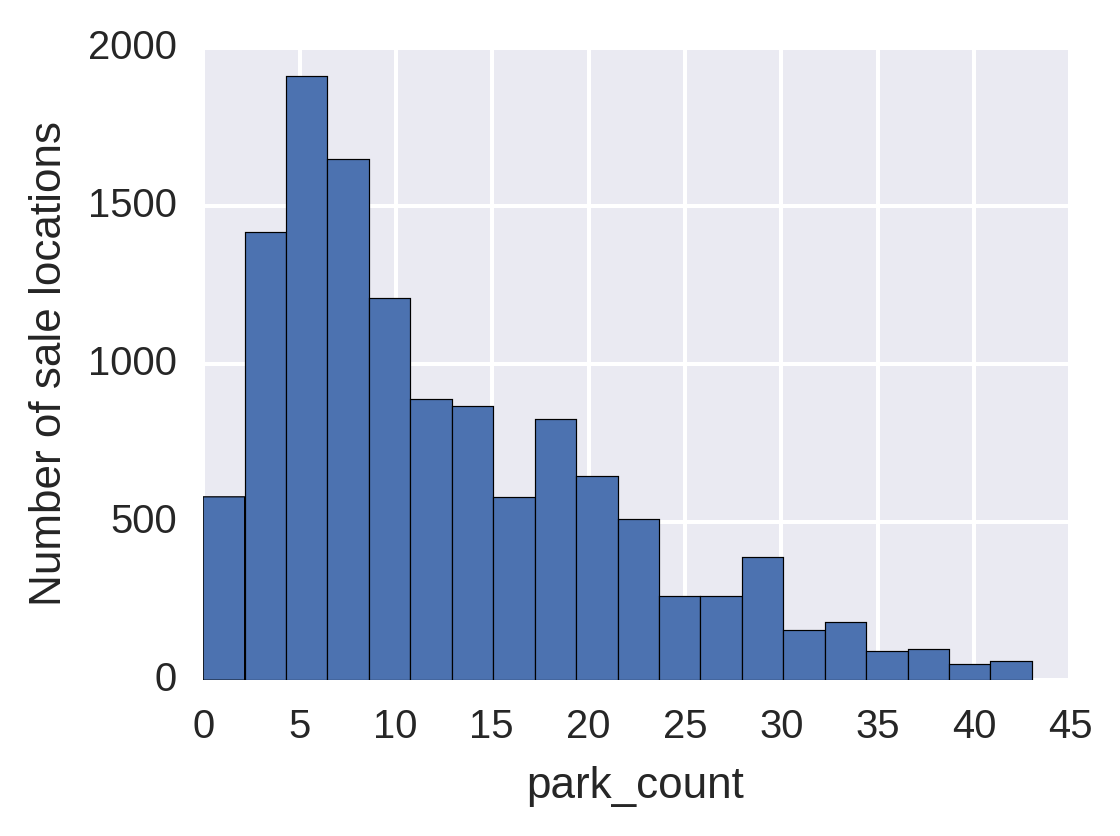

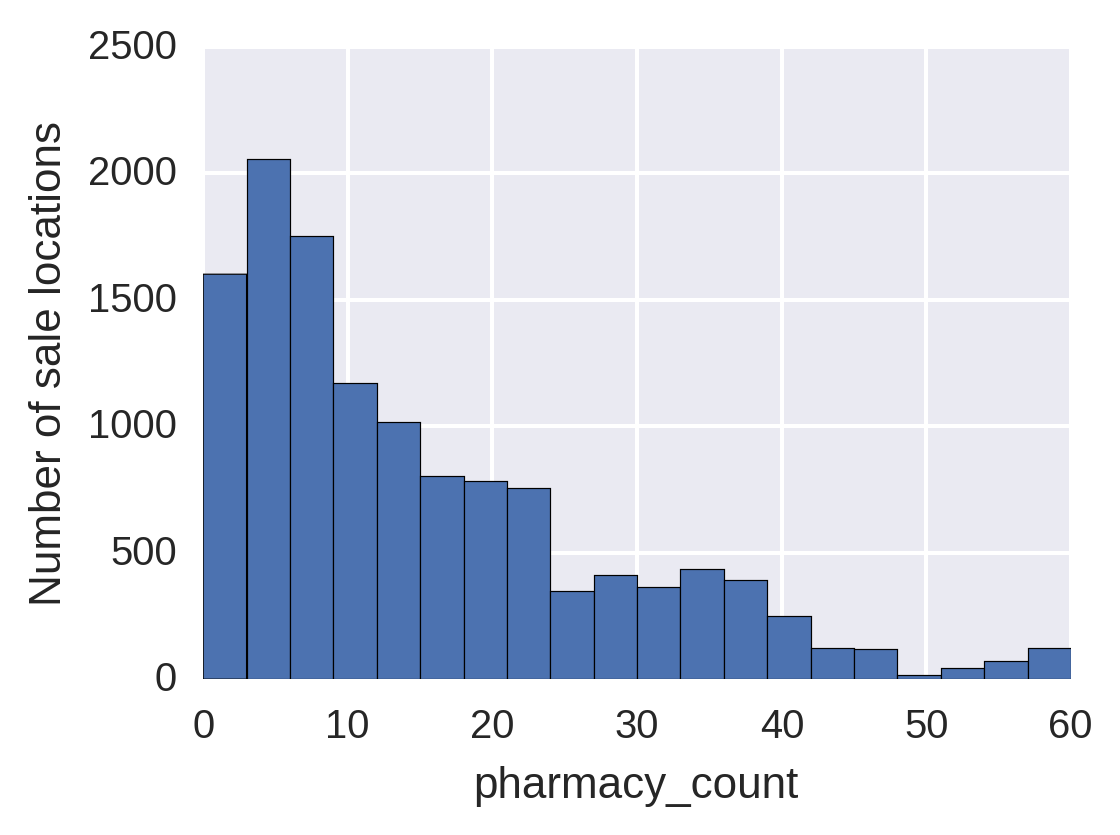

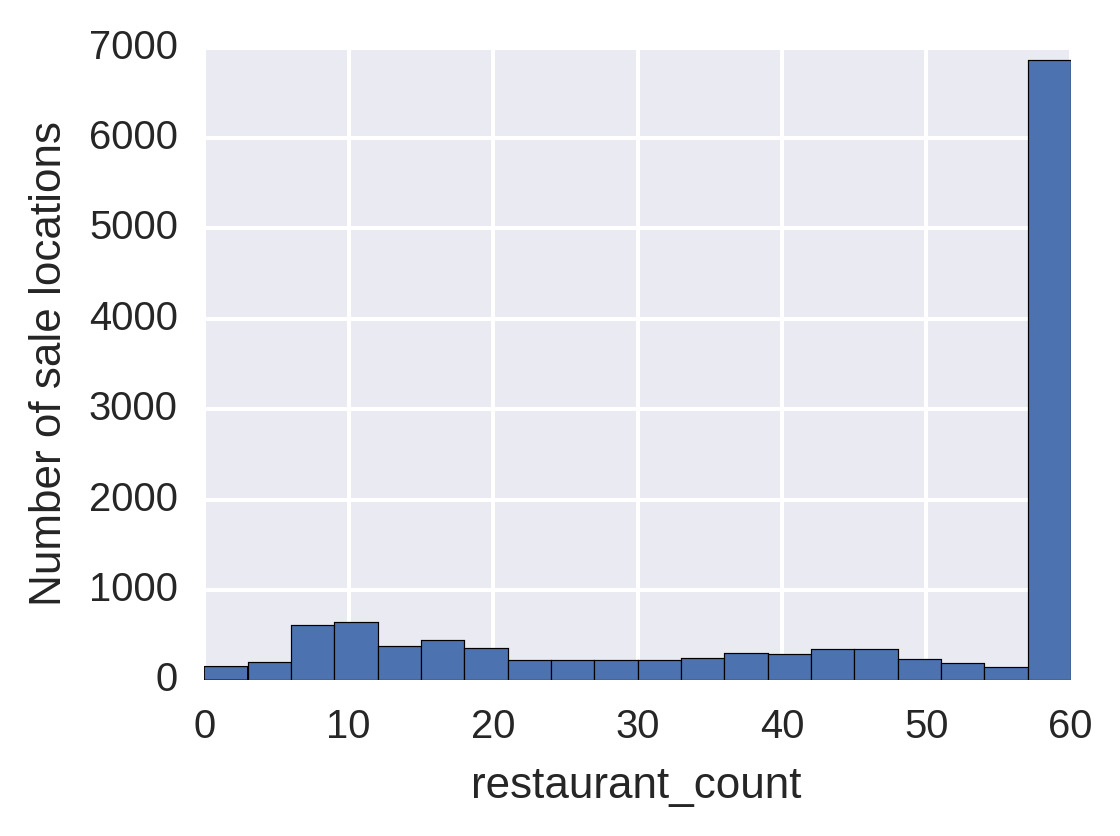

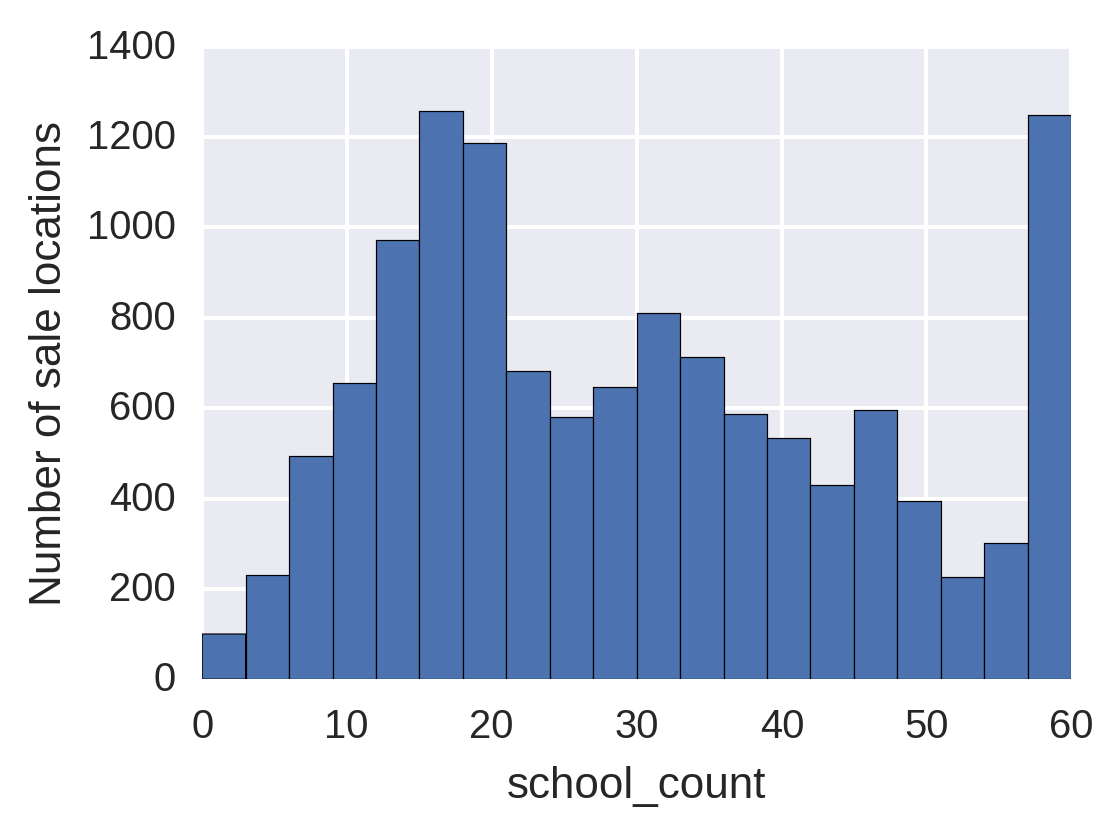

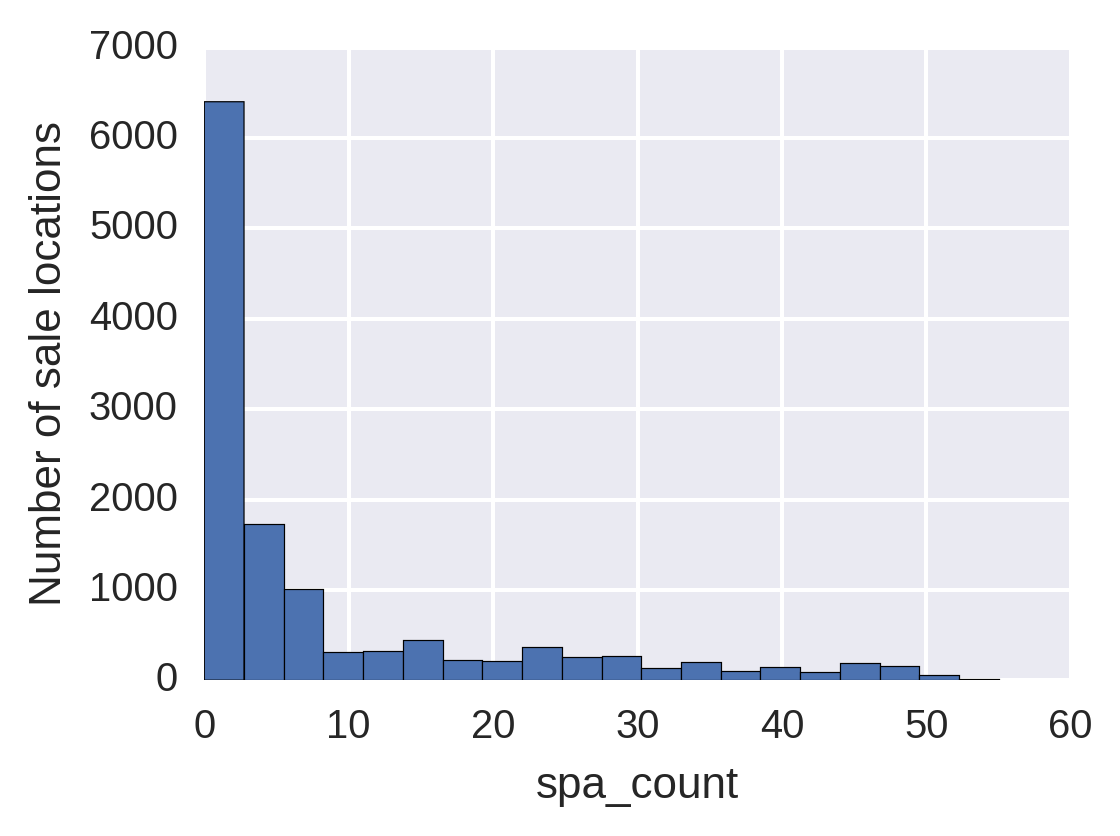

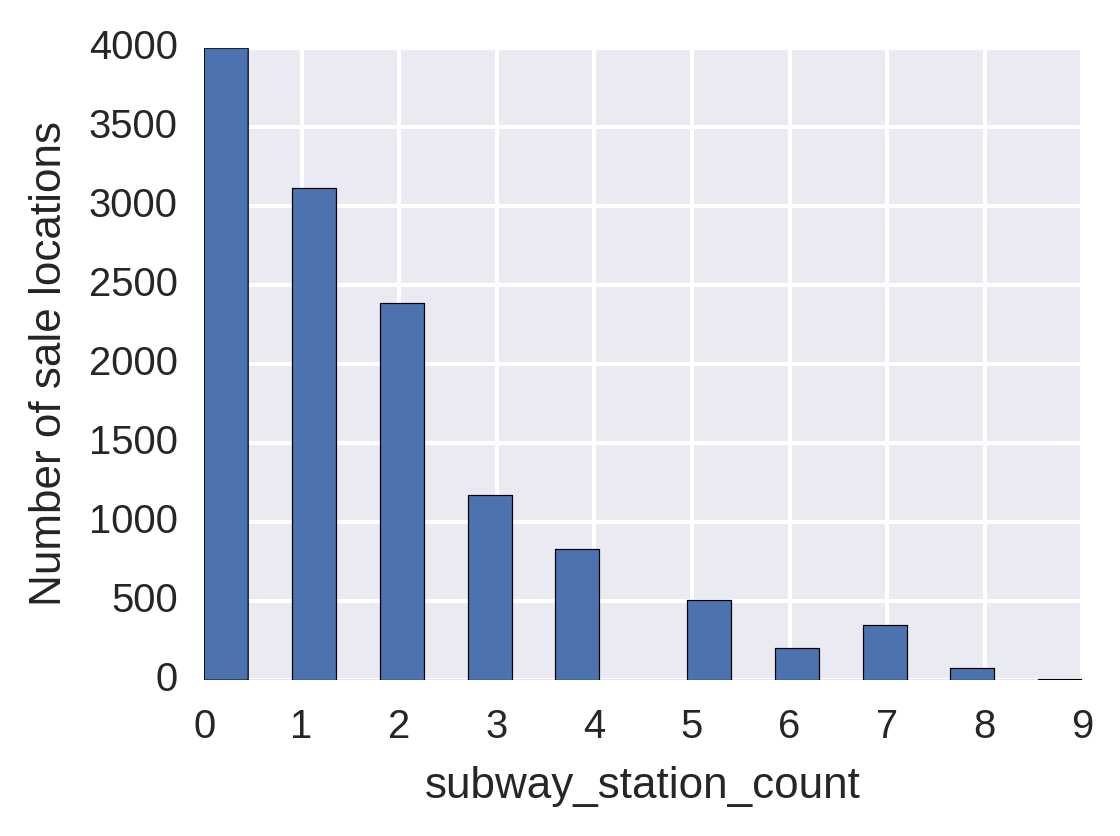

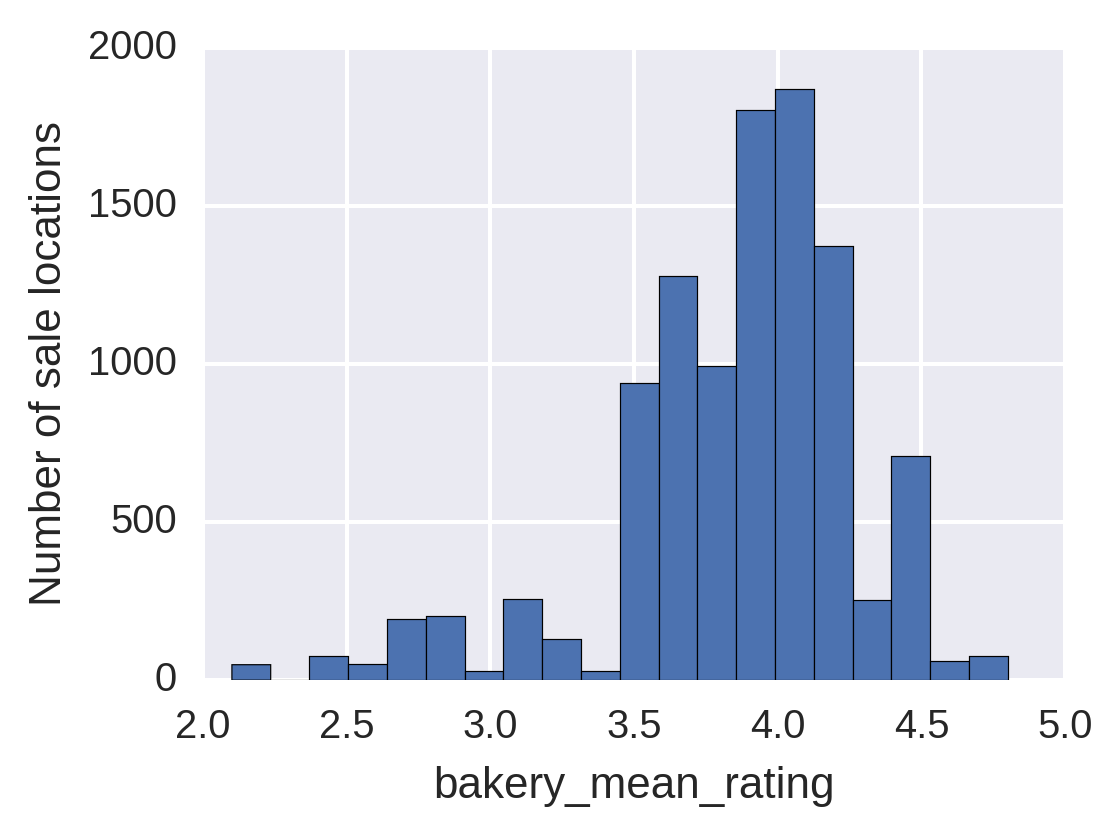

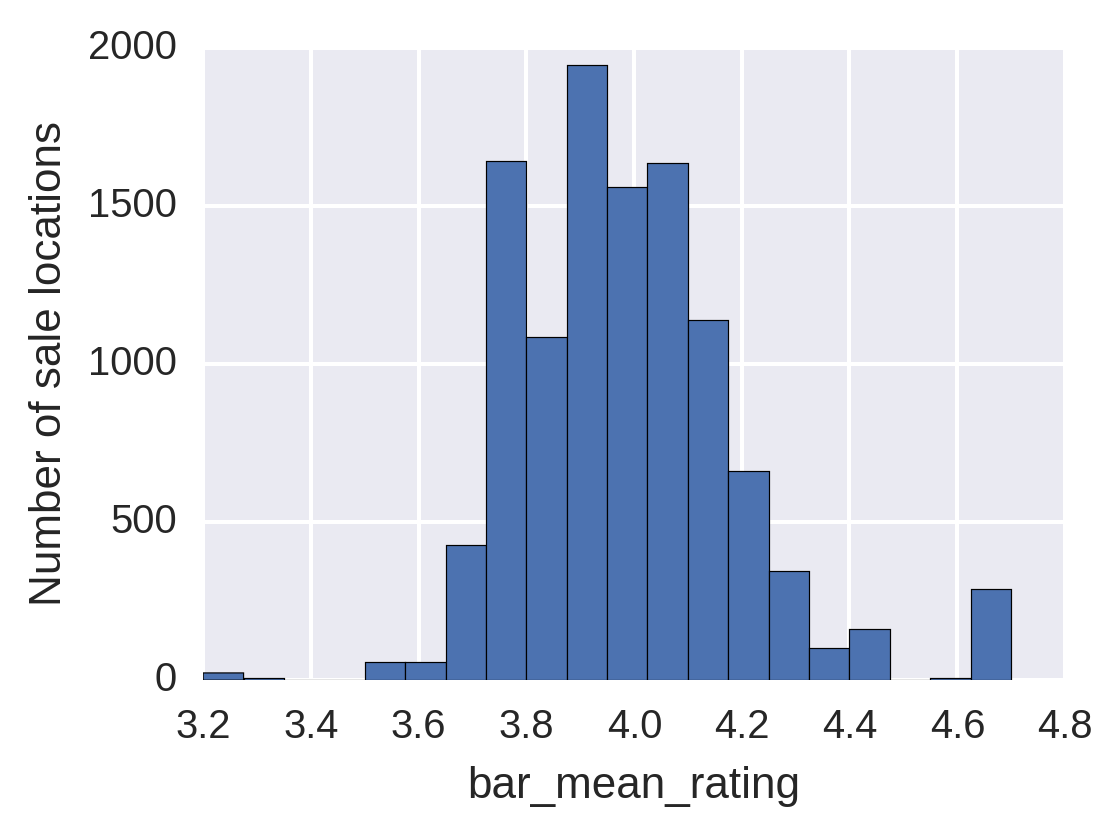

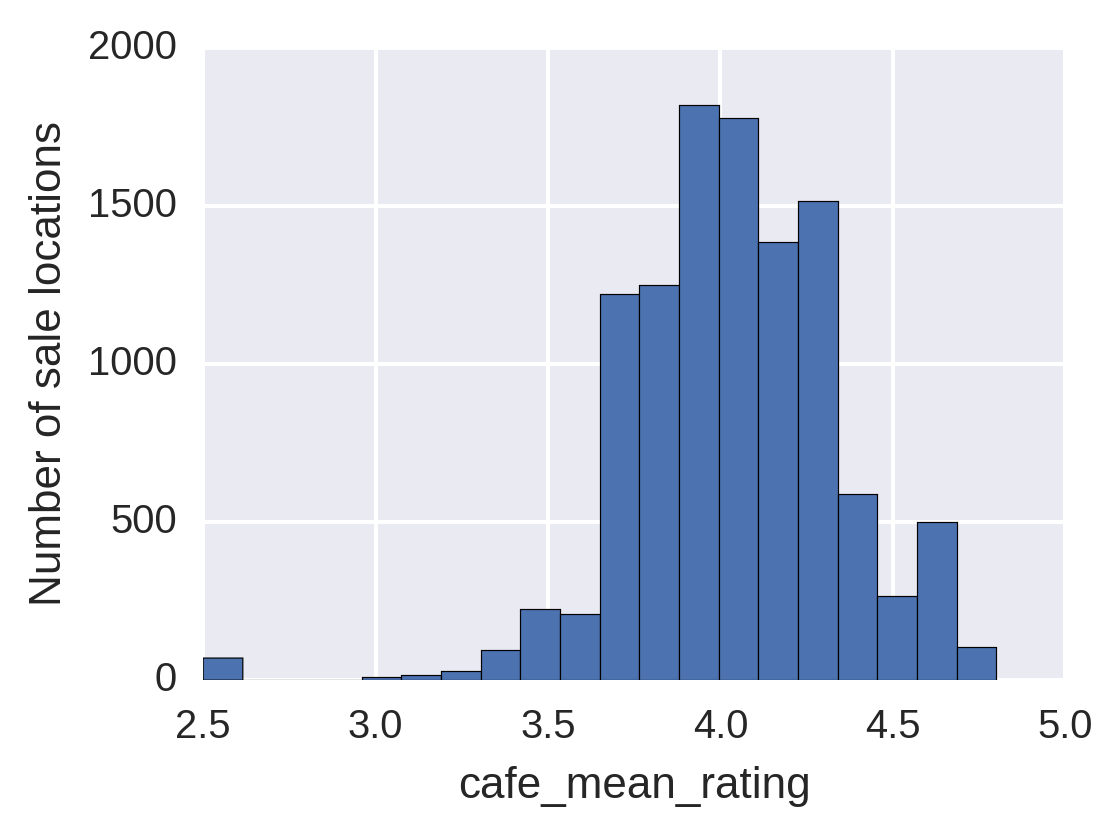

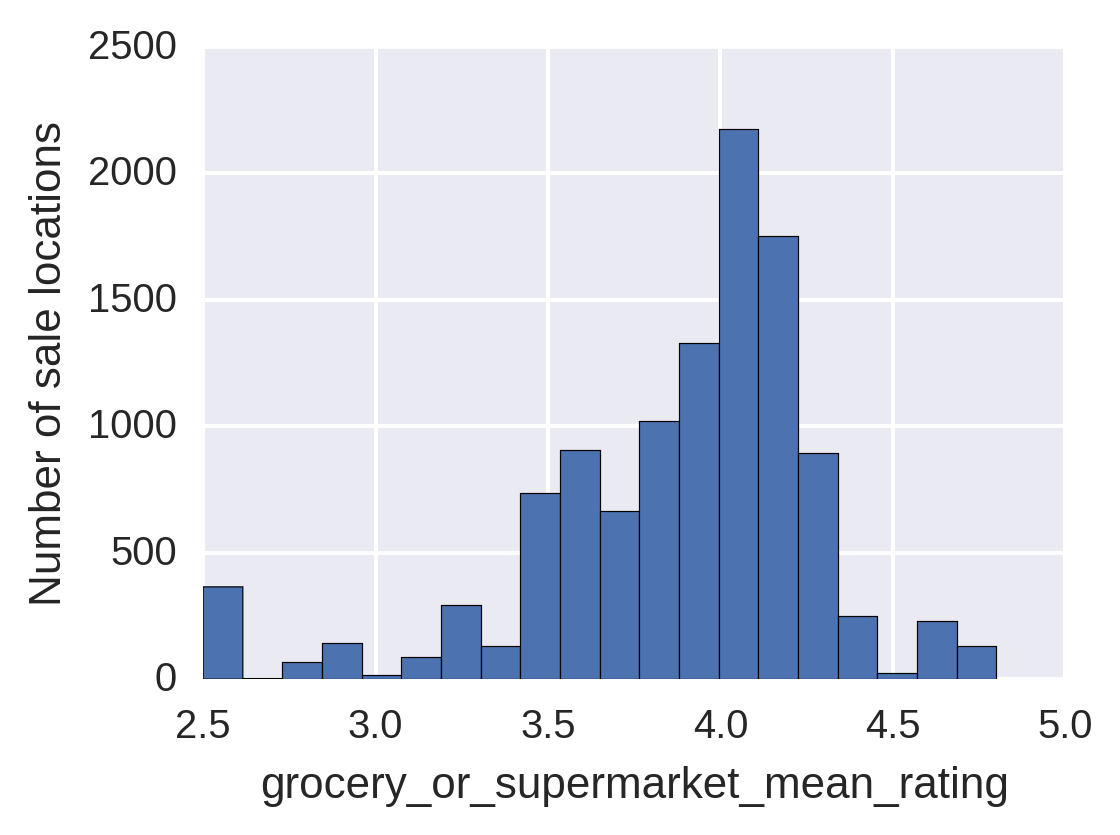

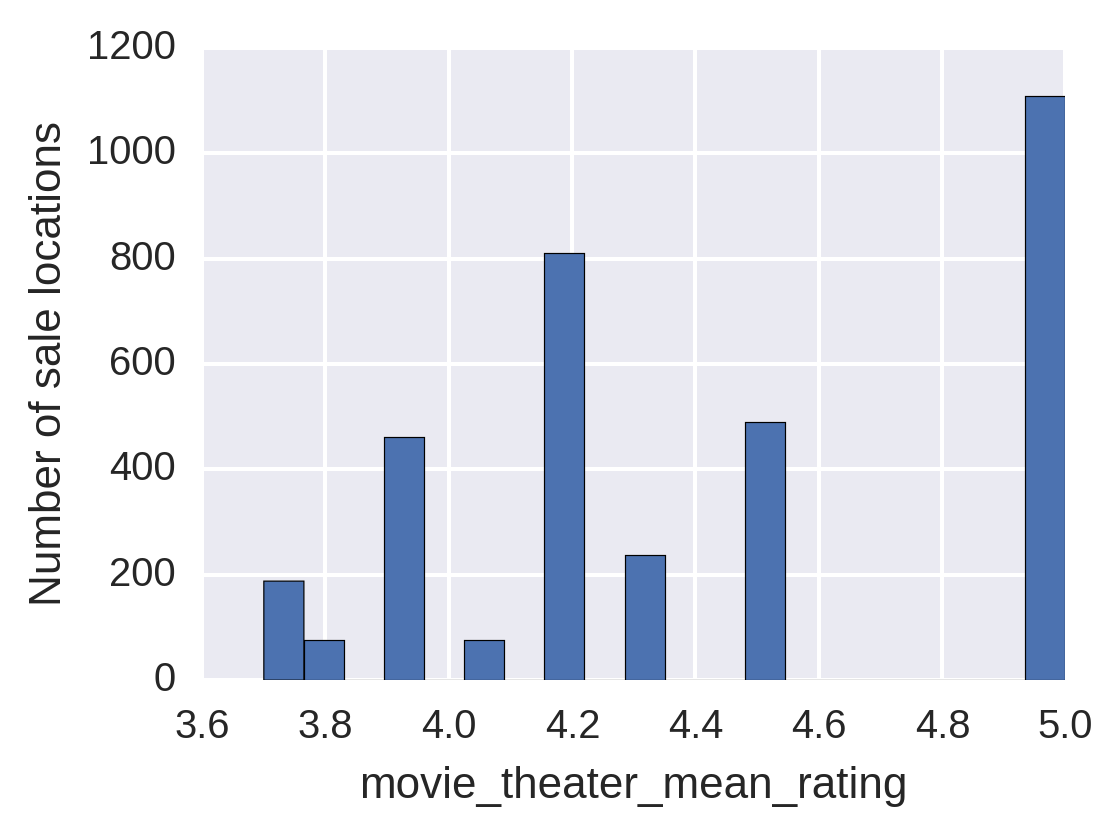

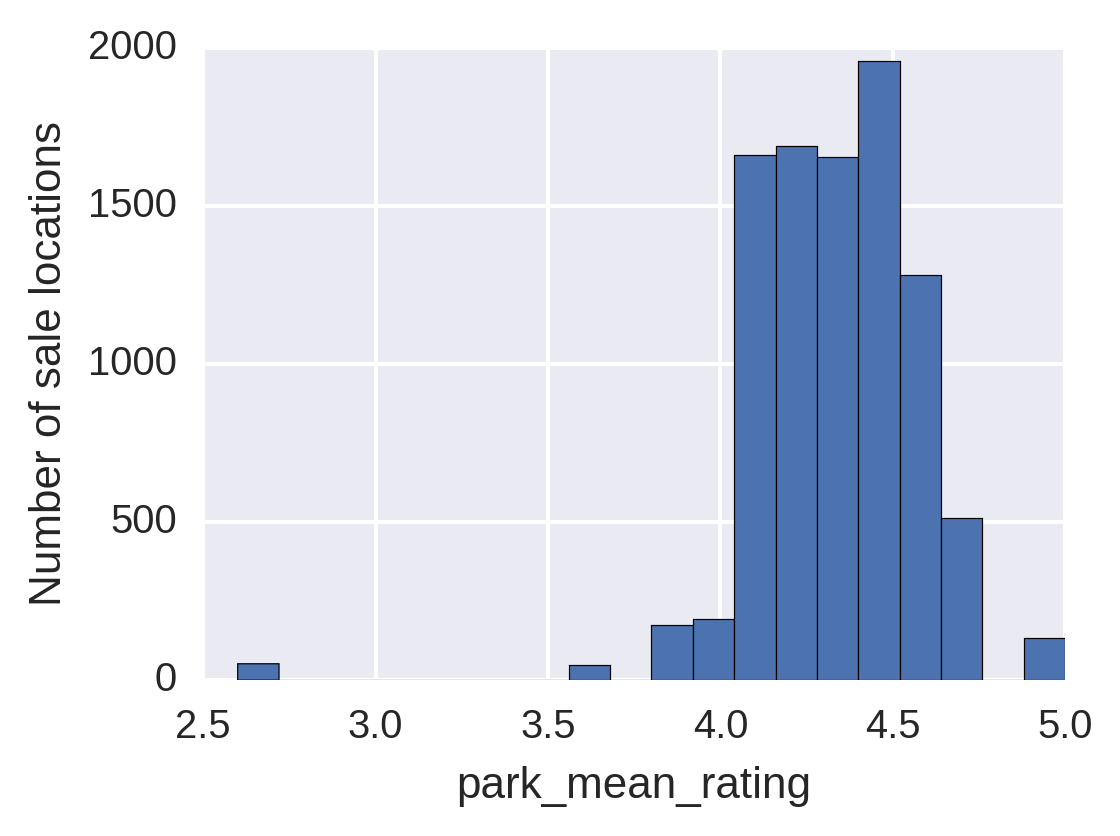

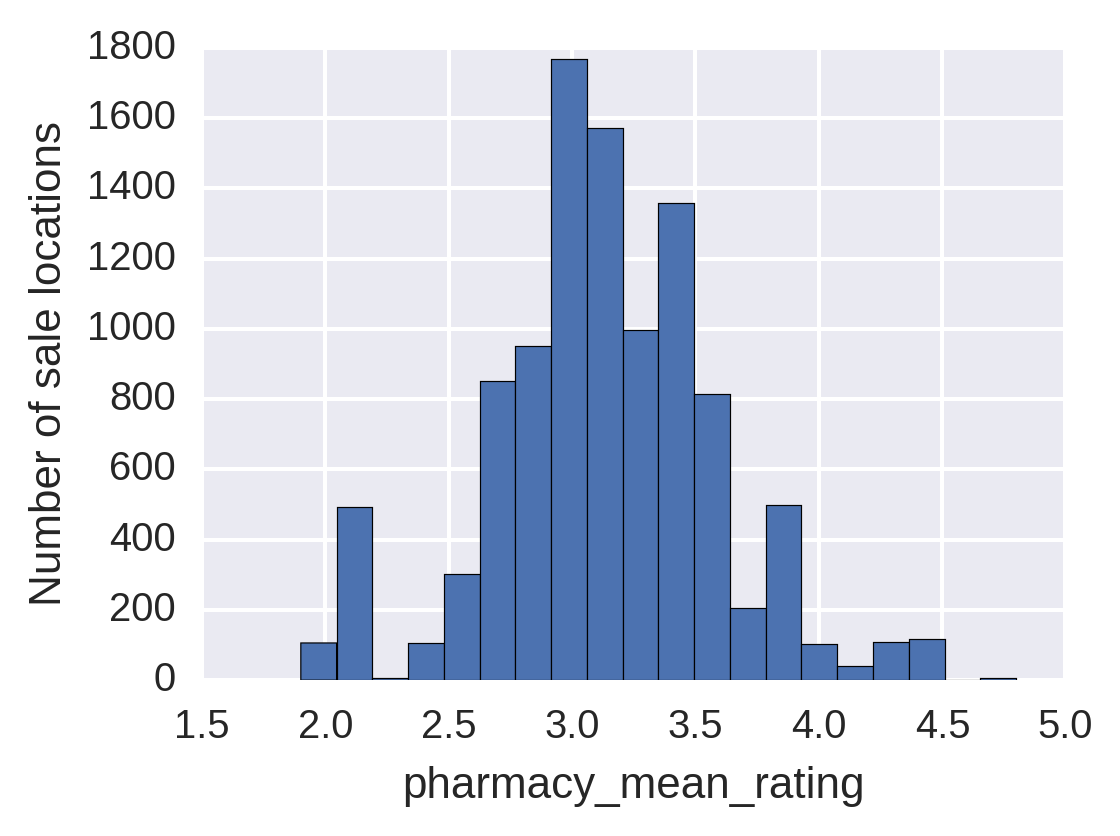

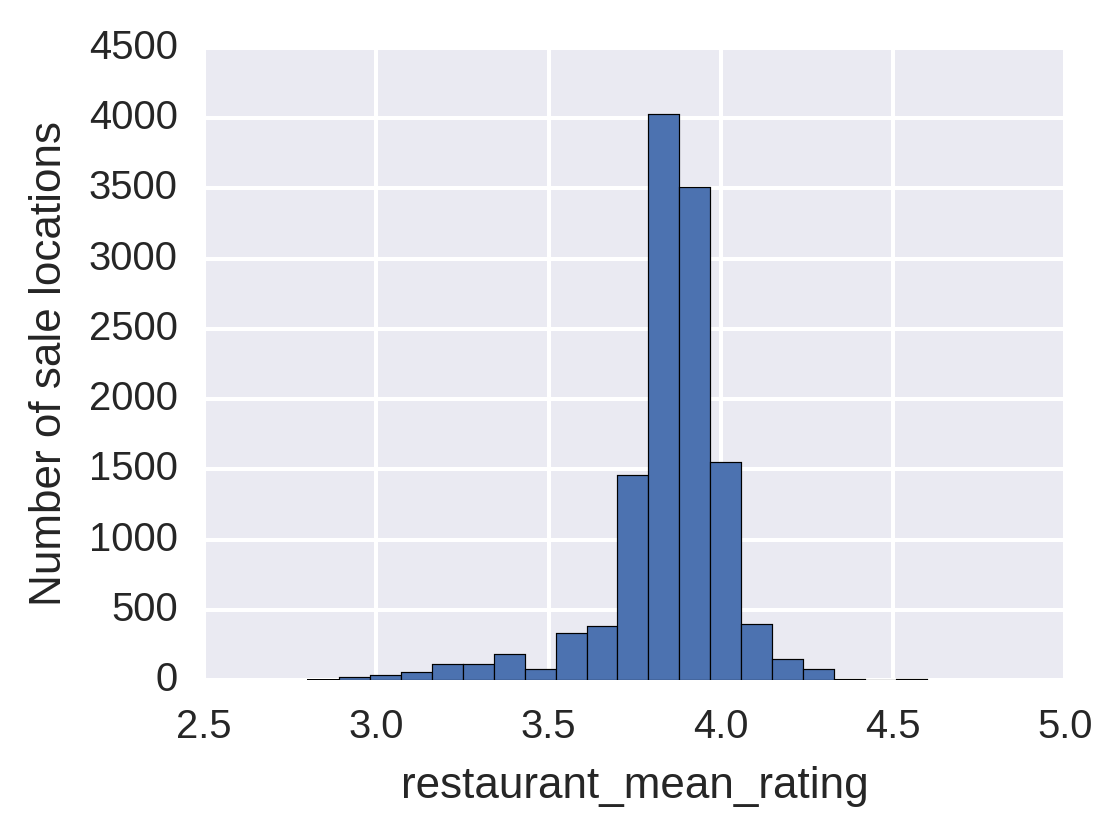

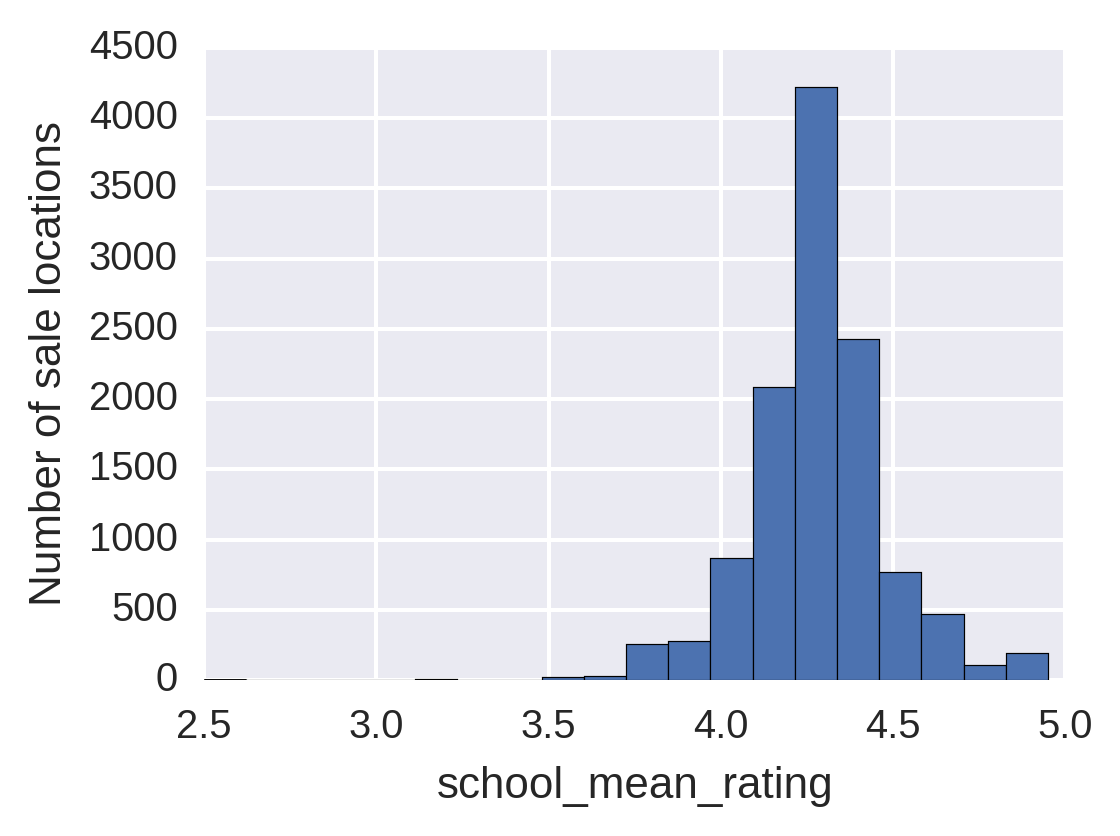

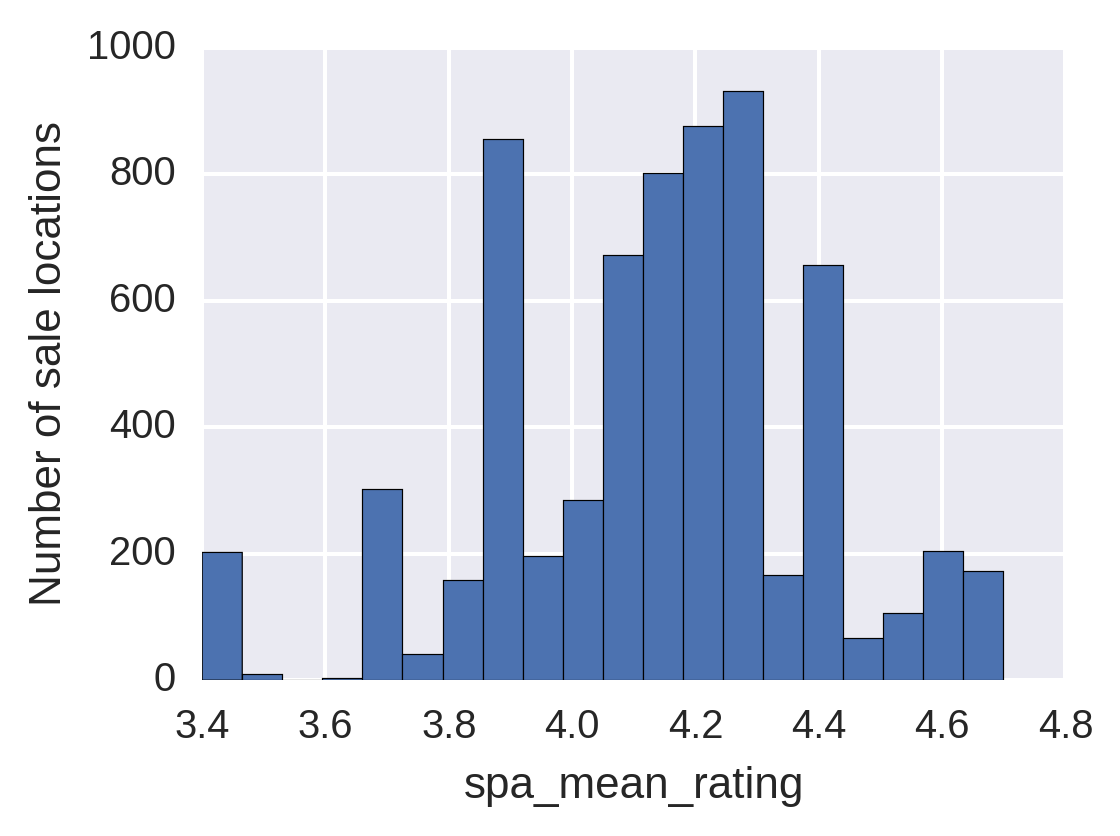

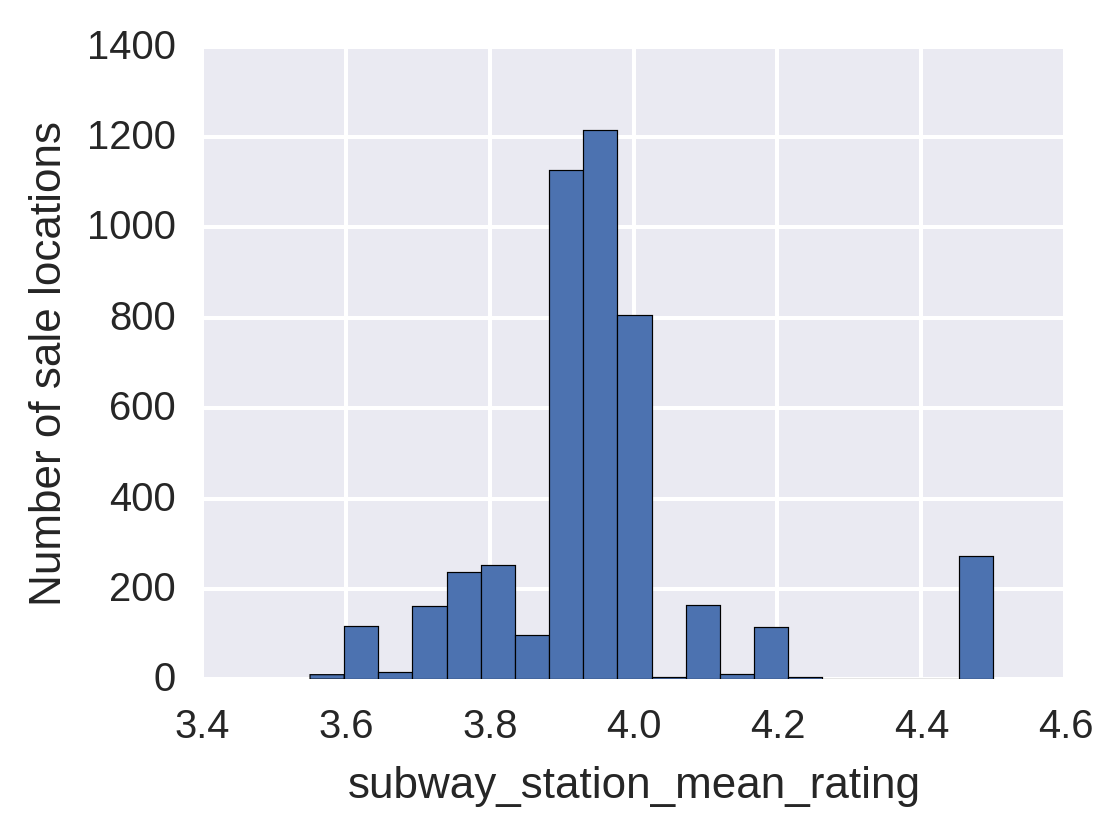

In [42]:
hist_plotter(df,(col for col in df.columns if '_count' in col and '_count_' not in col),'count_')
hist_plotter(df,(col for col in df.columns if '_mean_rating' in col),'rating_')


In [ ]:
df.plot?

In [ ]:
def scatter_plotter(df,attr,title=None):
  df.plot(kind='scatter',x=attr,y='SALEPRICE',figsize=(4,3))
  plt.xlabel(attr)
  plt.yscale('log')
  plt.title(title)

In [ ]:
for name, group in df.groupby('zipcode'):
  #print name, len(group.index)
  if len(group.index)>5:
    scatter_plotter(group,'grocery_or_supermarket_mean_rating',name)

In [ ]:
scatter_plotter(group,'cafe_count')

#Do some modeling

In [ ]:
df = pd.read_hdf('./data/df_w_amen_flat.hd5','df')

In [ ]:
df.groupby('zipcode').count()

In [ ]:
def grid_score_plotter(cv,param,title=None):
  cv_accuracy = pd.DataFrame.from_records(
      [(score.parameters[param],
        score.mean_validation_score)
       for score in cv.grid_scores_],
  columns=[param, 'accuracy'])

  plt.plot(cv_accuracy[param], cv_accuracy.accuracy)
  plt.xlabel(param)
  plt.ylabel('accuracy')
  plt.title(title)
  plt.show()

In [ ]:
X = df
y = df.SALEPRICE

## Build a predictive model using only latitude and longitude using K-nearest neighbors ##

In [ ]:
from sklearn import cross_validation, grid_search, neighbors

lat_lng_pipe = Pipeline([
    ('sel',ColumnSelectTransformer(['latitude','longitude'])),
    ('knn',neighbors.KNeighborsRegressor())
  ])

param_grid = {"knn__n_neighbors": range(1,6)}
lat_lng_model = grid_search.GridSearchCV( lat_lng_pipe,
                param_grid=param_grid,
                cv=cross_validation.ShuffleSplit(len(df.index), n_iter=20, 
                    test_size=0.2, random_state=42) )

lat_lng_model.fit(X,y)

for key in param_grid.keys():
  grid_score_plotter(lat_lng_model,key)

In [ ]:
computed_error = pd.DataFrame(
  {'lat_lng_err': (y - lat_lng_model.predict(X))**2
  })
computed_error.mean()

```python
ensemble.RandomForestRegressor?
from sklearn import cross_validation, grid_search, ensemble

param_grid = {"min_samples_split":range(5,8,2)}
lat_lng_model = grid_search.GridSearchCV( ensemble.RandomForestRegressor(),
                param_grid=param_grid,
                cv=cross_validation.ShuffleSplit(len(df.index), n_iter=20, 
                    test_size=0.2, random_state=42) )

lat_lng_model.fit(df[['latitude','longitude']],df['SALEPRICE'])
for key in param_grid.keys():
  grid_score_plotter(lat_lng_model,key)
```

In [ ]:
import scipy as sp
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion

class ColumnSelectTransformer(BaseEstimator, TransformerMixin):
  """
  Select columns of data from nd array
  """
  def __init__(self, columns):
    ''' columns must be list of strings '''
    self.columns = columns

  def fit(self, X, y):
    return self

  def transform(self, X):
    ''' Assume X is pandas dataframe '''
    return X[self.columns]
    
class ShellTransformer(BaseEstimator, TransformerMixin):
  '''Pass the fitted fitted_model into the init function
  and predict during the transform step'''
  def __init__(self,fitted_model):
    self.fitted_model = fitted_model
    pass
  
  def fit(self,X,y=None):
    return self

  def transform(self,X):
    '''Here, X is a pandas DataFrame'''
    return self.fitted_model.predict(X)
 
class ReshapeTransformer(BaseEstimator, TransformerMixin):
  '''Pass the fitted fitted_model into the init function
  and predict during the transform step'''
  def __init__(self,ncols):
    self.ncols = ncols
    pass
  
  def fit(self,X,y=None):
    return self

  def transform(self,X):
    '''Here, X is an nd array'''
    return X.reshape((X.size/self.ncols,self.ncols),order='F')
  
full_pipe = Pipeline([
  ('union', FeatureUnion([
              ('lat_lng_model',ShellTransformer(lat_lng_model)),
              ('landarea',ColumnSelectTransformer('LANDAREA')),
        ]) ),  
  ('reshaper', ReshapeTransformer(2)),
  ('mod', linear_model.LinearRegression())
])

X = df
y = df.SALEPRICE

full_pipe.fit(X,y)

if False:
  with open('p_full_model.dpkl','wb') as p_output:
    pickle.dump(full_pipe,p_output)

In [ ]:
computed_error['comb_error'] = (y - full_pipe.predict(X))**2
computed_error.apply(lambda x: np.sqrt(np.mean(x)))

In [ ]:
param_grid = {"n_neighbors": range(1,6)}

if False:
  for name, group in df.groupby('zipcode'):
    if len(group.index)>5:
      lat_lng_model = grid_search.GridSearchCV( neighbors.KNeighborsRegressor(),
                  param_grid=param_grid,
                  cv=cross_validation.ShuffleSplit(len(group.index), n_iter=20, 
                      test_size=0.2, random_state=42) )
      lat_lng_model.fit(group[['latitude','longitude']],group['SALEPRICE'])
      for key in param_grid.keys():
        grid_score_plotter(lat_lng_model,key,name)

In [ ]:
df['saledate_int'] = pd.to_datetime(df['SALEDATE'])
df['saledate_int'] = df['saledate_int'].astype(np.int64)

In [ ]:
ax = df.plot(kind='scatter',x='LANDAREA',y='SALEPRICE')
plt.yscale('log')

In [ ]:
ax = df.plot(kind='scatter',x='saledate_int',y='SALEPRICE')
plt.yscale('log')

In [ ]:
from sklearn import linear_model
from sklearn import cross_validation, grid_search

amen_model = grid_search.GridSearchCV( linear_model.Ridge(),
                param_grid={'alpha':np.logspace(0.7,1.5,5)},
                cv=cross_validation.ShuffleSplit(len(dfs.index), n_iter=20, 
                    test_size=0.2, random_state=42) )

dfs = df.loc[np.invert(np.isnan(df.bar_mean_rating)),:]

amen_model.fit(dfs[['bar_mean_rating']],dfs['SALEPRICE'])
grid_score_plotter(amen_model,'alpha')

## Build a predictive model using only latitude and longitude using random forest regressor ##

In [ ]:
from sklearn import ensemble

param_grid = {"min_samples_leaf": range(1,10), 'min_samples_split': range(2,10,2)}
ll_rf_model = grid_search.GridSearchCV(ensemble.RandomForestRegressor(n_jobs=-1),
                param_grid=param_grid,
                cv=cross_validation.ShuffleSplit(len(df.index), n_iter=20, 
                    test_size=0.2,) )

ll_rf_model.fit(df[['latitude','longitude']],df['SALEPRICE'])
for key in param_grid.keys():
  grid_score_plotter(ll_rf_model,key)

In [ ]:
ll_rf_model.grid_scores_[0][1]

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

xs = []
ys = []
zs = []
for gs in ll_rf_model.grid_scores_:
  xs.append(gs[0]['min_samples_leaf'])
  ys.append(gs[0]['min_samples_split'])
  zs.append(gs[1])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs, ys, zs, zdir='z', s=20, depthshade=True)



In [ ]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn import linear_model
from sklearn import cross_validation, grid_search
import numpy as np



```python
import simplejson as json
from requests import Request, Session
import pandas as pd
from multiprocessing import Pool
from collections import namedtuple
from itertools import izip, repeat

# Read in all API keys
with open("../secrets/google_secrets.json.nogit") as fh: 
  secrets = json.loads(fh.read())
google_api_key = secrets['server_api_key']

# Define amenity types of interest
AMENITY_TYPES = ['bakery','bar','cafe','grocery_or_supermarket',
  'movie_theater','park','pharmacy','restaurant','school','spa','subway_station']

Place = namedtuple('Place',['name','lat_lng','rating','price_level'])

def google_places_parser((query_str,lat_lng_str)):
  ''' Search through up three pages of up to 20 results each'''
  search_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"
    
  search_payload = {"key":google_api_key,
                    "radius":1000,
                    "types":query_str}
  
  url = search_url+'?location='+lat_lng_str  

  places_list = []
  rcnt = 0
  while True and rcnt<3:
    with requests.Session() as s:
      resp = s.get(url,params=search_payload)
    rcnt +=1
      
    for r in resp.json()['results']:
      name = r.get('name')
      lat_lng = str(r['geometry']['location']['lat']) + ',' + str(r['geometry']['location']['lng'])
      rating = r.get('rating')
      price_level = r.get('price_level')
      places_list.append(Place(name,lat_lng,rating,price_level))
    
    npt = resp.json().get('next_page_token','')
    if npt == '':
      break
    else:
      search_payload.update({'page_token':npt})
    
  return places_list


def get_amenities(query_str, lat_lng_series):
  ''' Given an amenity-type query string and an nd-array-like
  lat_lng_series, return a list of list of results'''

  p = Pool(7)
  
  place_lists = p.map(google_places_parser, izip(repeat(query_str),lat_lng_series))
  return place_lists

```

###When places have the same name, use the haversine formula to determine if they refer to the same place.

```python
from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    return km
  
haversine(-77.020269,38.894629,-77.0325204,38.9039343)
```